In [6]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rania121","key":"214a81c41cafd2a04cf2b029606405a5"}'}

In [7]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Find the dataset URL on Kaggle (e.g., https://www.kaggle.com/datasets/username/dataset-name), then run:

In [3]:
!kaggle datasets download -dpaultimothymooney/chest-xray-pneumonia

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
chest-xray-pneumonia.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
!unzip chest-xray-pneumonia.zip


Archive:  chest-xray-pneumonia.zip
replace chest_xray/__MACOSX/._chest_xray? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

### **Importing libraries**

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
import cv2
import shutil
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping , ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import precision_score, recall_score, f1_score


### **Knowing the count of image in each file**

In [9]:
base_dir = 'chest_xray'

subsets = ['train', 'val', 'test']
categories = ['NORMAL', 'PNEUMONIA']

for subset in subsets:
    print(f"\nSubset: {subset}")
    for category in categories:
        folder = os.path.join(base_dir, subset, category)
        count = len(os.listdir(folder))
        print(f"  {category}: {count} images")



Subset: train
  NORMAL: 1341 images
  PNEUMONIA: 3875 images

Subset: val
  NORMAL: 8 images
  PNEUMONIA: 8 images

Subset: test
  NORMAL: 234 images
  PNEUMONIA: 390 images


### **Plotting random images**

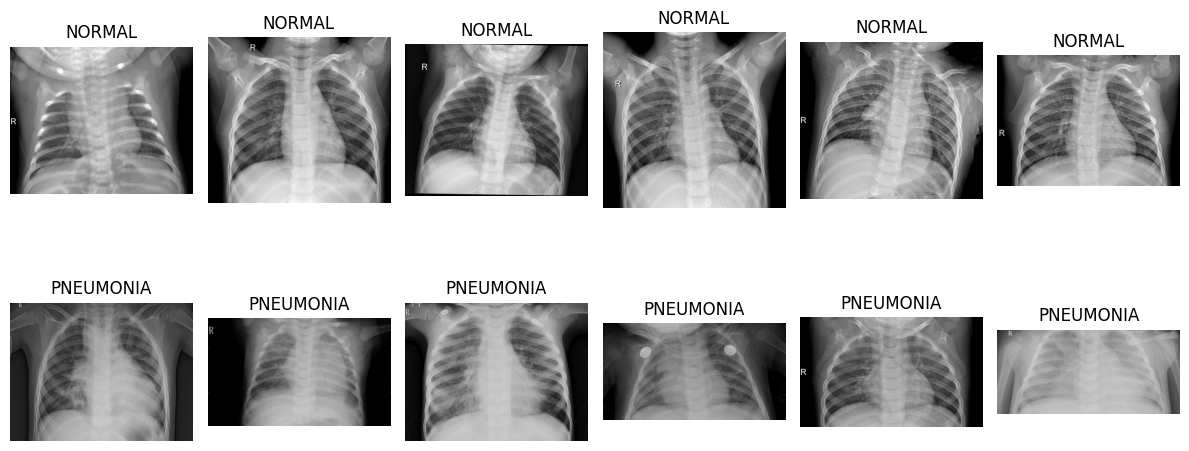

In [10]:
normal_path = os.path.join(base_dir, 'train', 'NORMAL')
pneumonia_path = os.path.join(base_dir, 'train', 'PNEUMONIA')

normal_samples = random.sample(os.listdir(normal_path), 6)
pneumonia_samples = random.sample(os.listdir(pneumonia_path), 6)

plt.figure(figsize=(12, 6))
for i in range(6):
    img = cv2.imread(os.path.join(normal_path, normal_samples[i]), cv2.IMREAD_GRAYSCALE)
    plt.subplot(2, 6, i+1)
    plt.imshow(img, cmap='gray')
    plt.title("NORMAL")
    plt.axis('off')

    img = cv2.imread(os.path.join(pneumonia_path, pneumonia_samples[i]), cv2.IMREAD_GRAYSCALE)
    plt.subplot(2, 6, i+7)
    plt.imshow(img, cmap='gray')
    plt.title("PNEUMONIA")
    plt.axis('off')

plt.tight_layout()
plt.show()


/tmp/ipython-input-2913990324.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_counts, x='Category', y='Count', palette='pastel', edgecolor='black')


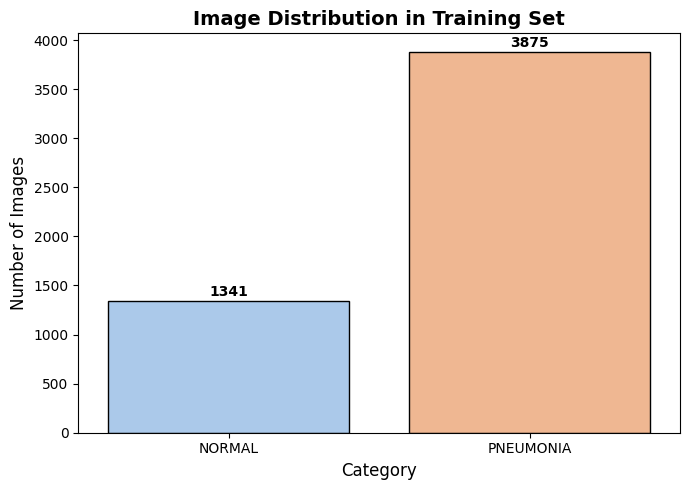

In [30]:
normal_count = len(os.listdir(normal_path))
pneumonia_count = len(os.listdir(pneumonia_path))

df_counts = pd.DataFrame({
    'Category': ['NORMAL', 'PNEUMONIA'],
    'Count': [normal_count, pneumonia_count]
})

plt.figure(figsize=(7, 5))
sns.barplot(data=df_counts, x='Category', y='Count', palette='pastel', edgecolor='black')
plt.title('Image Distribution in Training Set', fontsize=14, fontweight='bold')
plt.xlabel('Category', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
for i, count in enumerate(df_counts['Count']):
    plt.text(i, count + 50, str(count), ha='center', fontsize=10, fontweight='bold')
plt.tight_layout()
plt.show()


NORMAL and PNEUMONIA images generally following a linear width-height relationship, but PNEUMONIA images tend to be slightly smaller

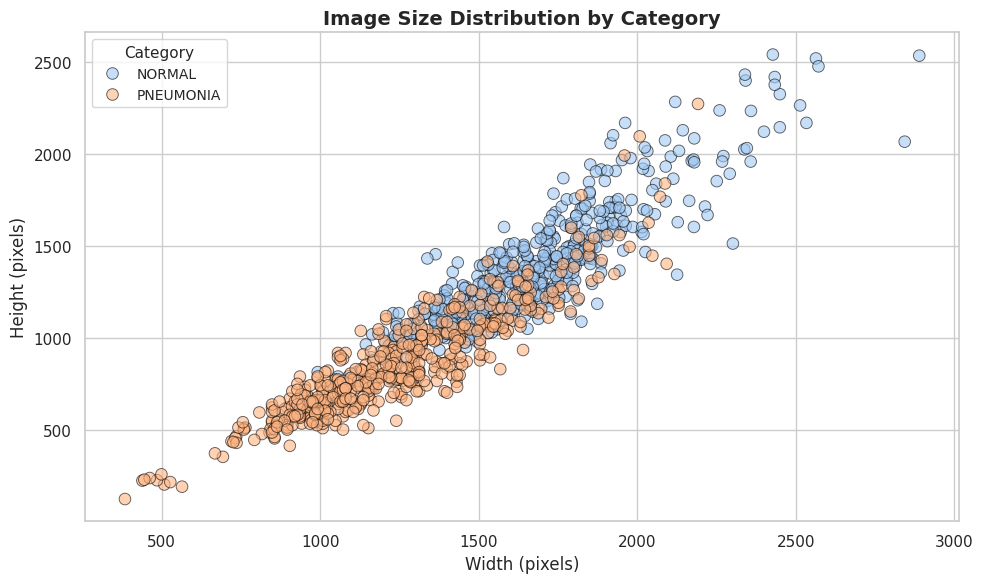

In [32]:
image_shapes = []

for category in ['NORMAL', 'PNEUMONIA']:
    path = os.path.join(base_dir, 'train', category)
    for file in os.listdir(path)[:500]:
        img = cv2.imread(os.path.join(path, file))
        if img is not None:
            h, w, _ = img.shape
            image_shapes.append((w, h, category))

df_shapes = pd.DataFrame(image_shapes, columns=['Width', 'Height', 'Category'])

plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

sns.scatterplot(
    data=df_shapes,
    x='Width',
    y='Height',
    hue='Category',
    palette='pastel',
    alpha=0.6,
    s=70,
    edgecolor='black'
)

plt.title('Image Size Distribution by Category', fontsize=14, fontweight='bold')
plt.xlabel('Width (pixels)', fontsize=12)
plt.ylabel('Height (pixels)', fontsize=12)
plt.legend(title='Category', fontsize=10, title_fontsize=11)
plt.tight_layout()
plt.show()


In [13]:
from PIL import Image

corrupted = []

for category in ['NORMAL', 'PNEUMONIA']:
    path = os.path.join(base_dir, 'train', category)
    for file in os.listdir(path):
        try:
            img = Image.open(os.path.join(path, file))
            img.verify()
        except:
            corrupted.append(file)

print(f"Number of corrupted images: {len(corrupted)}")


Number of corrupted images: 0


## **First try**

I split the train data to train and validation



In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    os.path.join(base_dir, 'train'),
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    color_mode='grayscale',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    os.path.join(base_dir, 'train'),
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    color_mode='grayscale',
    subset='validation'
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    os.path.join(base_dir, 'test'),
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    color_mode='grayscale',
    shuffle=False
)

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
train_labels = train_generator.classes

class_names = list(train_generator.class_indices.keys())  # ['NORMAL', 'PNEUMONIA']

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)

class_weights_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weights_dict)

Class Weights: {0: np.float64(1.9445479962721341), 1: np.float64(0.6730645161290323)}


In [ ]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,193 (12.60 MB)

 Trainable params: 3,304,193 (12.60 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(train_generator, validation_data=val_generator, epochs=15, class_weight=class_weights_dict, verbose=1, batch_size=32)

Epoch 1/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.5332 - loss: 0.6401

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


131/131 ━━━━━━━━━━━━━━━━━━━━ 50s 360ms/step - accuracy: 0.5343 - loss: 0.6394 - val_accuracy: 0.7498 - val_loss: 0.5068
Epoch 2/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 43s 331ms/step - accuracy: 0.8157 - loss: 0.3986 - val_accuracy: 0.8437 - val_loss: 0.3466
Epoch 3/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 47s 356ms/step - accuracy: 0.8366 - loss: 0.3500 - val_accuracy: 0.8370 - val_loss: 0.3314
Epoch 4/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 43s 331ms/step - accuracy: 0.8584 - loss: 0.3232 - val_accuracy: 0.8284 - val_loss: 0.3627
Epoch 5/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 47s 361ms/step - accuracy: 0.8630 - loss: 0.3059 - val_accuracy: 0.8667 - val_loss: 0.3055
Epoch 6/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 42s 319ms/step - accuracy: 0.8703 - loss: 0.3073 - val_accuracy: 0.7843 - val_loss: 0.4792
Epoch 7/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 44s 340ms/step - accuracy: 0.8684 - loss: 0.2865 - val_accuracy: 0.8734 - val_loss: 0.2767
Epoch 8/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 43s 328ms/step - accuracy: 0.8927 - loss: 0.2495 - val

In [ ]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")


20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 170ms/step - accuracy: 0.8418 - loss: 0.4530
Test Accuracy: 0.8910
Test Loss: 0.2990


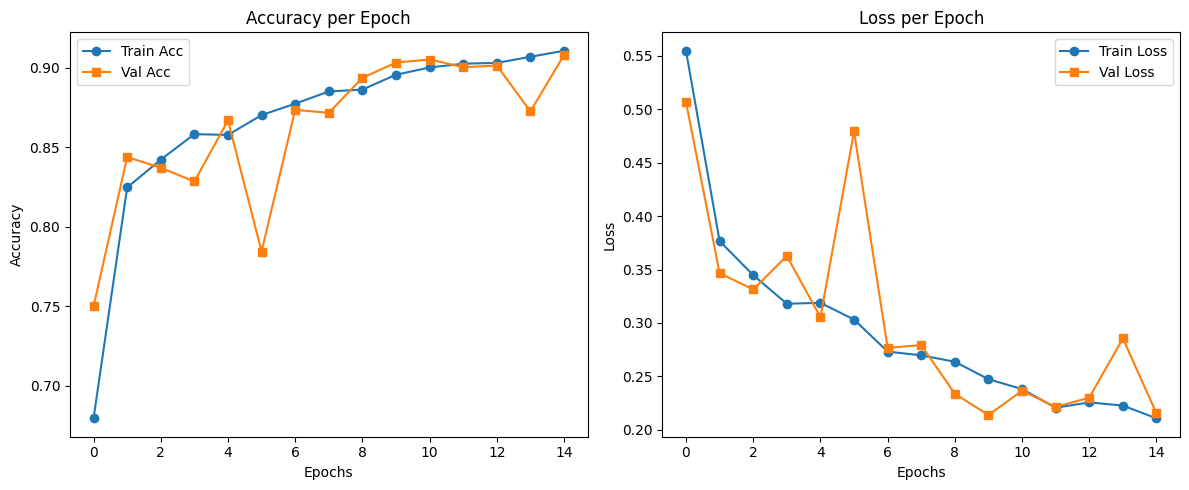

In [ ]:
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Acc', marker='s')
plt.title('Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='s')
plt.title('Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
y_pred_probs = model.predict(test_generator)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

y_true = test_generator.classes

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 170ms/step


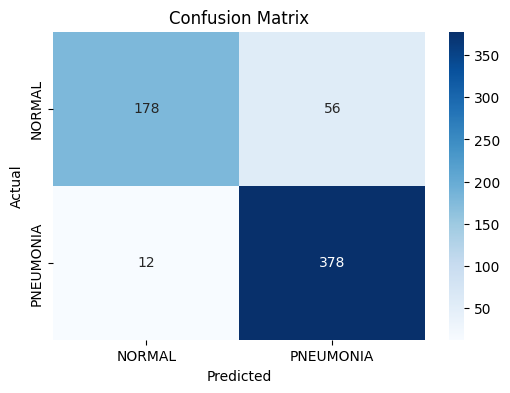

Classification Report:

              precision    recall  f1-score   support

      NORMAL       0.94      0.76      0.84       234
   PNEUMONIA       0.87      0.97      0.92       390

    accuracy                           0.89       624
   macro avg       0.90      0.86      0.88       624
weighted avg       0.90      0.89      0.89       624



In [ ]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 164ms/step


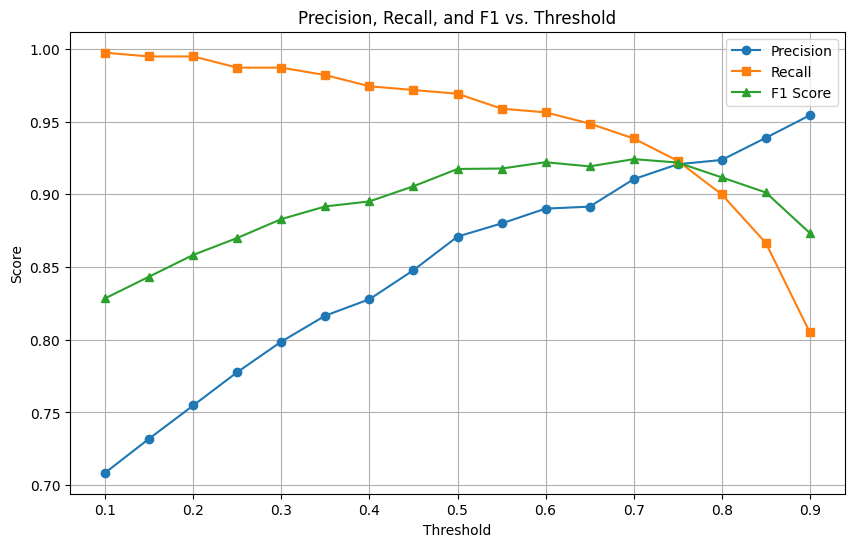

In [ ]:
y_probs = model.predict(test_generator).flatten()
y_true = test_generator.classes

thresholds = np.arange(0.1, 0.91, 0.05)
precisions = []
recalls = []
f1s = []

for t in thresholds:
    y_pred = (y_probs > t).astype(int)
    precisions.append(precision_score(y_true, y_pred))
    recalls.append(recall_score(y_true, y_pred))
    f1s.append(f1_score(y_true, y_pred))

plt.figure(figsize=(10,6))
plt.plot(thresholds, precisions, label='Precision', marker='o')
plt.plot(thresholds, recalls, label='Recall', marker='s')
plt.plot(thresholds, f1s, label='F1 Score', marker='^')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 vs. Threshold')
plt.legend()
plt.grid(True)
plt.show()




In [ ]:
y_pred_probs = model.predict(test_generator)
y_pred = (y_pred_probs > 0.7).astype(int).flatten()

y_true = test_generator.classes

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step


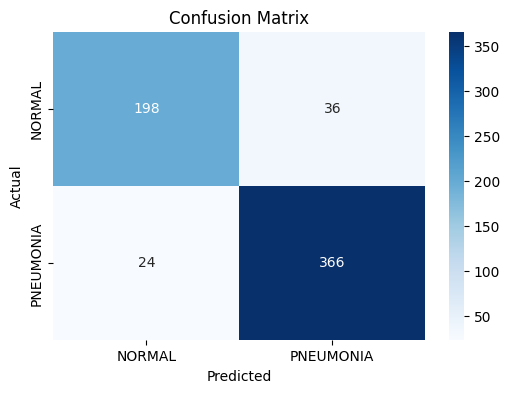

Classification Report:

              precision    recall  f1-score   support

      NORMAL       0.89      0.85      0.87       234
   PNEUMONIA       0.91      0.94      0.92       390

    accuracy                           0.90       624
   macro avg       0.90      0.89      0.90       624
weighted avg       0.90      0.90      0.90       624



In [ ]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

## **Second try**

I thought about gathering the three folders and splitting the data into train , val , test to improve the imbalance.

In [14]:
def collect_all_images(base_dir='chest_xray/chest_xray', target_dir='all'):
    source_dirs = ['train', 'val', 'test']
    classes = ['NORMAL', 'PNEUMONIA']

    for cls in classes:
        target_class_dir = os.path.join(target_dir, cls)
        os.makedirs(target_class_dir, exist_ok=True)

        for split in source_dirs:
            source_class_dir = os.path.join(base_dir, split, cls)
            if os.path.exists(source_class_dir):
                for filename in os.listdir(source_class_dir):
                    src = os.path.join(source_class_dir, filename)
                    dst = os.path.join(target_class_dir, f"{split}_{filename}")
                    shutil.copy2(src, dst)


def split_dataset(source_dir='all', dest_dir='splitted_data', split_ratio=(0.7, 0.15, 0.15)):
    classes = ['NORMAL', 'PNEUMONIA']
    for cls in classes:
        img_list = os.listdir(os.path.join(source_dir, cls))
        random.shuffle(img_list)

        total = len(img_list)
        train_end = int(split_ratio[0] * total)
        val_end = train_end + int(split_ratio[1] * total)

        train_files = img_list[:train_end]
        val_files = img_list[train_end:val_end]
        test_files = img_list[val_end:]

        for split, files in zip(['train', 'val', 'test'], [train_files, val_files, test_files]):
            split_path = os.path.join(dest_dir, split, cls)
            os.makedirs(split_path, exist_ok=True)
            for file in files:
                src = os.path.join(source_dir, cls, file)
                dst = os.path.join(split_path, file)
                shutil.copy2(src, dst)


def print_dataset_summary(dest_dir='splitted_data'):
    for split in ['train', 'val', 'test']:
        for cls in ['NORMAL', 'PNEUMONIA']:
            folder = os.path.join(dest_dir, split, cls)
            count = len(os.listdir(folder)) if os.path.exists(folder) else 0
            print(f"{split}/{cls}: {count}")

collect_all_images()
split_dataset()
print_dataset_summary()


train/NORMAL: 1581
train/PNEUMONIA: 4267
val/NORMAL: 878
val/PNEUMONIA: 2418
test/NORMAL: 905
test/PNEUMONIA: 2385


In [15]:
train_dir = 'splitted_data/train'
val_dir = 'splitted_data/val'
test_dir = 'splitted_data/test'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    shear_range=0.1
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    color_mode='grayscale',
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(128, 128),
    color_mode='grayscale',
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    color_mode='grayscale',
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 5844 images belonging to 2 classes.
Found 3292 images belonging to 2 classes.
Found 3287 images belonging to 2 classes.


In [16]:
train_labels = train_generator.classes
class_names = list(train_generator.class_indices.keys())

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)

class_weights_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weights_dict)


Class Weights: {0: np.float64(1.850538315389487), 1: np.float64(0.6851113716295428)}


In [17]:
model3 = models.Sequential([
    layers.Input(shape=(128, 128, 1)),

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model3.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,193 (12.60 MB)

 Trainable params: 3,304,193 (12.60 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

model3.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])

history = model3.fit(train_generator, validation_data=val_generator, epochs=50, callbacks=[early_stop], class_weight=class_weights_dict)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 94s 484ms/step - accuracy: 0.5441 - loss: 0.6871 - val_accuracy: 0.9058 - val_loss: 0.2578
Epoch 2/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 70s 381ms/step - accuracy: 0.8415 - loss: 0.3696 - val_accuracy: 0.8621 - val_loss: 0.3393
Epoch 3/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 62s 339ms/step - accuracy: 0.8686 - loss: 0.3174 - val_accuracy: 0.9228 - val_loss: 0.2091
Epoch 4/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 62s 337ms/step - accuracy: 0.8745 - loss: 0.3009 - val_accuracy: 0.9274 - val_loss: 0.1907
Epoch 5/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 67s 365ms/step - accuracy: 0.8902 - loss: 0.2790 - val_accuracy: 0.9013 - val_loss: 0.2365
Epoch 6/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 71s 387ms/step - accuracy: 0.9005 - loss: 0.2587 - val_accuracy: 0.9095 - val_loss: 0.2327
Epoch 7/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 70s 383ms/step - accuracy: 0.9068 - loss: 0.2404 - val_accuracy: 0.8906 - val_loss: 0.2842


In [21]:
test_loss, test_acc = model3.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


103/103 ━━━━━━━━━━━━━━━━━━━━ 27s 264ms/step - accuracy: 0.9176 - loss: 0.2098
Test Accuracy: 0.9273
Test Loss: 0.1943


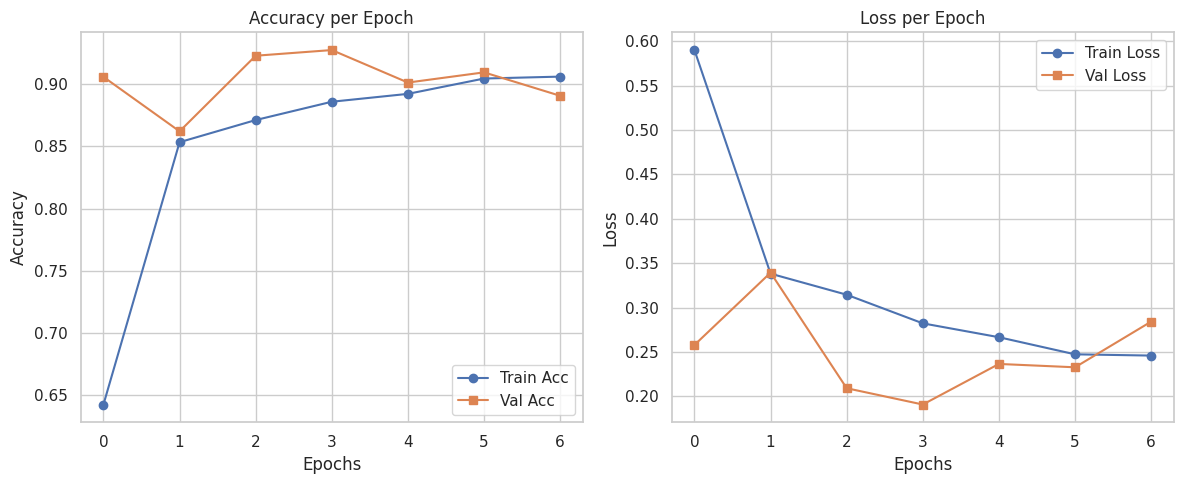

In [33]:
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Acc', marker='s')
plt.title('Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='s')
plt.title('Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


103/103 ━━━━━━━━━━━━━━━━━━━━ 20s 187ms/step


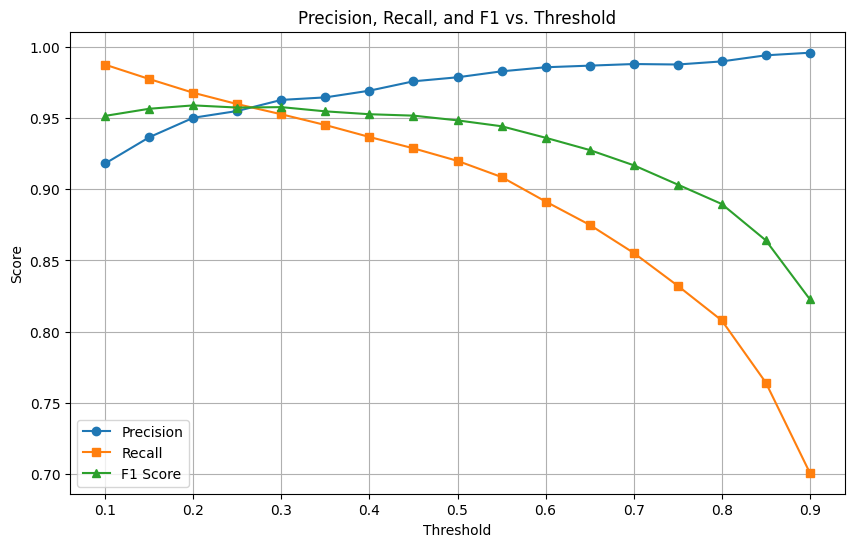

In [22]:
y_probs = model3.predict(test_generator).flatten()
y_true = test_generator.classes

thresholds = np.arange(0.1, 0.91, 0.05)
precisions = []
recalls = []
f1s = []

for t in thresholds:
    y_pred = (y_probs > t).astype(int)
    precisions.append(precision_score(y_true, y_pred))
    recalls.append(recall_score(y_true, y_pred))
    f1s.append(f1_score(y_true, y_pred))

plt.figure(figsize=(10,6))
plt.plot(thresholds, precisions, label='Precision', marker='o')
plt.plot(thresholds, recalls, label='Recall', marker='s')
plt.plot(thresholds, f1s, label='F1 Score', marker='^')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 vs. Threshold')
plt.legend()
plt.grid(True)
plt.show()




In [27]:
y_pred_probs = model3.predict(test_generator)
y_pred = (y_pred_probs > 0.3).astype(int).flatten()

y_true = test_generator.classes

103/103 ━━━━━━━━━━━━━━━━━━━━ 20s 196ms/step


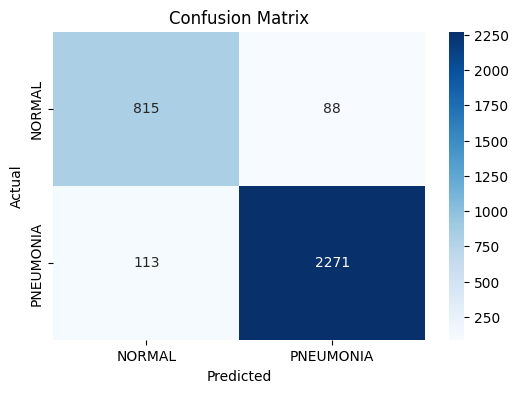

Classification Report:

              precision    recall  f1-score   support

      NORMAL       0.88      0.90      0.89       903
   PNEUMONIA       0.96      0.95      0.96      2384

    accuracy                           0.94      3287
   macro avg       0.92      0.93      0.92      3287
weighted avg       0.94      0.94      0.94      3287



In [28]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

### Insights from Data Splitting Strategies

- **First Split**: Used only the `train` folder, splitting it into train and validation; test set had 624 images.
  - **Accuracy**: 90%
  - **F1-scores**: NORMAL = 0.87, PNEUMONIA = 0.92
  - **Insight**: Limited data for training and testing led to moderate performance and less reliable evaluation.

- **Second Split**: Merged all data (train, val, test) and then re-split into train, validation, and test.
  - **Accuracy**: 94%
  - **F1-scores**: NORMAL = 0.89, PNEUMONIA = 0.96
  - **Insight**: More balanced and larger data in all sets improved the model's generalization and evaluation reliability.

- **Key Insight**: Properly splitting the **entire dataset** ensures better class distribution, reduces bias, and results in more robust performance metrics.
